In [3]:
%reload_ext autoreload
%autoreload 2

from src.acnets.deep.lemon_data import LEMONDataModule
import numpy as np
import torch
import torch.nn.functional  as F
import pywt
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:

datamodule = LEMONDataModule()
datamodule.setup()

ts_regions = datamodule.train[:][0] # -> shape: (subjects, timepoints, regions)
wt_regions = datamodule.train[:][5] # -> shape: (subjects, wavelets, regions)

torch.Size([3, 100, 160])

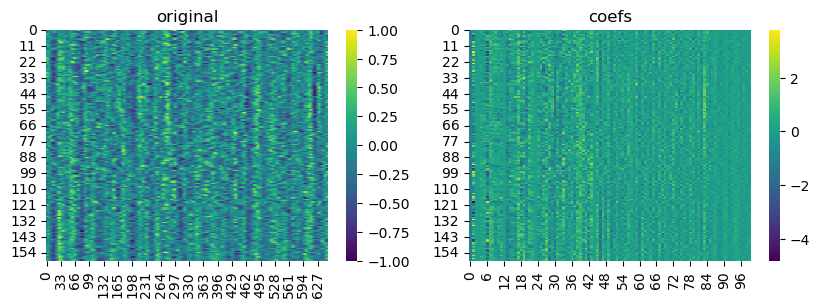

In [5]:

# DEBUG LOSS
# loss = F.mse_loss(torch.tensor(data).detach(),
#                   torch.tensor(data_recon).detach())
# # print('MSE', loss)

# DEBUG PLOT
plt.subplots(1, 2, figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title('original')
sns.heatmap(ts_regions[0].T, cmap='viridis')

plt.subplot(1, 2, 2)
plt.title('coefs')
sns.heatmap(wt_regions[0].T, cmap='viridis', label='coefs')
plt.show()